In [1]:
import subprocess
import warnings
import numpy as np
import pandas as pd
import time
import math
from scipy.stats import bernoulli as bn
from cyvcf2 import VCF, Writer, Variant
from typing import *
import os
import collections
from random import seed
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class SNPsPool(np.ndarray):
    """
    Simulates the different steps of a genotype pooling process.
    Builds the pooling design matrix.
    Encodes pooled genotypes per group.
    Decodes encoded genotypes of the pools back to individual genotypes.
    """
    def __new__(cls,
                shape: tuple = (4, 4),  #default, in case not assigned
                id_len: int = 8,
                pools_nb: int = 8,
                pools_size: int = 4) -> np.ndarray:
        """
        Define the basic structure for a pool i.e.
        a squared matrix to fill with the variables IDs/GT/GL.
        :param shape: tuple, shape of the pool
        :param id_len: max number of char of the variables IDs
        :return: a matrix with dims 'shape', filled with str types
        """
        cls.id_len = id_len
        id = 'U' + str(cls.id_len)
        cls.pools_nb = pools_nb
        cls.pools_size = pools_size
        return np.empty_like(super(SNPsPool, cls).__new__(cls, shape),
                             dtype=id)

    def design_matrix(self, random: bool = False) -> np.ndarray:
        """
        That function is not intended to be called explicitly.
        :param random: bool for dispatching idv randomly in the matrix?
        :return: design matrix. Numpy array.
        """
        pools_size: int = self.pools_size
        design: np.ndarray = np.zeros((self.pools_nb, self.size), dtype=int)
        if not random:
            for i in range(int(self.pools_nb/self.ndim)):
                j = i * pools_size
                design[i, j:j+pools_size] = [1]*pools_size
            for i in range(int(self.pools_nb/self.ndim), self.pools_nb):
                j = i - pools_size
                design[i,
                       [j+k*pools_size for k in range(pools_size)]] = 1
        return design

    def set_subset(self, subset: np.ndarray) -> np.ndarray:
        """
        Fills the pooling matrix according to the (default) design
        and the input list of samples.
        :param subset: 1D-nparray-like object with the variables IDs
        :return: pooling matrix with samples' names.
        """
        self.__setattr__('subset', subset)  # from split_pools
        sub = self.__getattribute__('subset')
        try:
            for i in range(self.shape[0]):
                self[i, :] = sub[:self.shape[1]]
                sub = sub[self.shape[1]:]
        except Exception as exc:
            if len(self.subset) > self.size:
                raise ValueError('The input you gave is too long') from exc
            if len(self.subset) < self.size:
                raise ValueError('The input you gave is too short') from exc
            if type(self.subset) != np.ndarray and type(self.subset) != list:
                raise TypeError('The input is not a 1D-array-like') from exc
            if len(self.subset) > 0 and type(self.subset[0]) != str:
                raise TypeError('The input does not contain str-type elements') from exc

        return self

    def get_subset(self) -> np.ndarray:
        """
        Flatten the matrix of pooled samples identifiers.
        :return: flattened array of samples identifiers or genotypes.
        """
        ids = self.flatten()  # .reshape(1, self.size)
        return ids

    def pools_list(self) -> List[str]:
        """
        Put samples into matrix structure, just for representation
        :return: list of matrix-shaped samples identifiers
        """
        design = self.design_matrix()
        if np.where(self == '', False, True).all():
            pools_: List[str] = []
            for i in range(design.shape[0]):
                cache = (design[i, :].reshape(self.shape) == False)  # cache = ~design[i, :].reshape(self.shape)
                pool = np.ma.masked_array(self, mask=cache)
                pools_.append(pool.compressed())
            return pools_
            # return just for being able to print the list if wished

    def set_line_values(self, samples: list, variant: Variant,
                        sig: object = None,
                        params: List[float] = [], interp: object = None) -> None:
        """
        Attach sigmoid-transformed alternate allele frequencies to the current variant.
        :param samples: samples identifiers from the VCF-file
        :param variant: variant identifier from the VCF-file
        :param sig: sigmoid object computed from another set of pooled genotype data
        :param params: parameters to pass for the sigmoid approximation
        :param interp: interpolated sigmoid object for sigmoid approximation
        :return: variant object with attributes attached, e.g. twisted alternate allele frequency
        """
        self.__setattr__('variant', variant)  #variant.genotypes
        self.__setattr__('samples', samples)


    def get_call(self) -> np.ndarray:
        """
        Get pooled samples genotypes for a given variant
        :return:
        """
        subs = self.get_subset()
        idx = np.argwhere(np.isin(self.samples, subs))
        self.__setattr__('call', np.asarray(self.variant)[idx])
        return self.call

    def pool_genotypes(self) -> np.ndarray:
        """
        Computes genotypes of the different pools.
        :return: array of {0,1} GLs for RR|RA|AA for each pool
        """
        call: np.ndarray = self.get_call().reshape((1, self.size, 3)) 
        scores: np.ndarray = np.apply_along_axis(sum, axis=-1, arr=call[:, :, :-1])
            
        

        if np.isin(call, -1).any():
            x = np.ones((1, self.pools_nb, 1))
            y = np.asarray([-1, -1, 0])
            b = np.broadcast(x, y)
            p = np.empty(b.shape)
            p.flat = [u * v for (u, v) in b]
        else:
            pooled_gt = np.dot(self.design_matrix(),
                               np.transpose(scores)).reshape((1, self.pools_nb, 1))
            
            pooled_gt = np.broadcast_to(pooled_gt, (1, self.pools_nb, 3))
            p = np.apply_along_axis(self.pooler_gt, axis=-1, arr=pooled_gt)

        return p  # list of gt for the n pools from design matrix

    def pooler_gt(self, a: np.ndarray) -> np.ndarray:
        """
        Decodes pooled scores into individual GT.
        :param a: score from matrix-vector pooling
        :return: pool's true genotype with phase
        """
        if np.all(a == 0):  # RR * RR * RR * RR
            gt = [0, 0, 0]
        elif np.all(a == self.pools_nb):  # AA * AA * AA * AA
            gt = [1, 1, 0]
        else:
            gt = [1, 0, 0]
        return gt

    def decode_genotypes_gt(self, samples_gt: np.ndarray) -> np.ndarray:
        """
        Recomputes true genotypes of samples with/without pooling/missing data
        :param pooled_samples: Variant.genotypes (unpooled samples' true genotypes with phase)
        :return: individual samples genotypes (true genotype with phase)
        """
        pooled: np.ndarray = self.pool_genotypes()  # pooled[:, :, -1]: bool = phase of the genotype
        scores: np.ndarray = np.apply_along_axis(sum, axis=-1, arr=pooled[:, :, :-1])
        p = np.argwhere(np.isin(self.samples, self.subset))
        
#         print('self.samples',self.samples) ############################################
#         print('self.subset',self.subset) ############################################
#         print('index of self.samples which is also in self.subset',p) ############################################

        count_alt: Callable[int, int] = lambda x: 1 if 1 in x else 0
        count_ref: Callable[int, int] = lambda x: 1 if 0 in x else 0

        alt_row: int = np.sum(np.apply_along_axis(count_alt,
                                                  axis=-1,
                                                  arr=pooled[:, :self.pools_size, :-1]))
        alt_col: int = np.sum(np.apply_along_axis(count_alt,
                                                  axis=-1,
                                                  arr=pooled[:, self.pools_size:, :-1]))
        ref_row: int = np.sum(np.apply_along_axis(count_ref,
                                                  axis=-1,
                                                  arr=pooled[:, :self.pools_size, :-1]))
        ref_col: int = np.sum(np.apply_along_axis(count_ref,
                                                  axis=-1,
                                                  arr=pooled[:, self.pools_size:, :-1]))

        nb_alt: int = alt_row + alt_col
        nb_ref: int = ref_row + ref_col
        
        if np.isin(pooled, -1).any():
            x = np.ones((1, self.size, 1))
            y = np.asarray([-1, -1, 0])
            b = np.broadcast(x, y)
            decoded_gt = np.empty(b.shape)
            decoded_gt.flat = [u * v for (u, v) in b]

        else:
            encoded = np.dot(scores,
                             self.design_matrix()).reshape(1, self.size, 1)
            b = np.broadcast_to(encoded, (1, self.size, 3))
            if nb_alt == 0:
                decoded_gt = np.zeros_like(b)
            elif nb_ref == 0:
                aa = np.array([1, 1, 0])
                decoded_gt = np.tile(aa, self.size).reshape((1, self.size, 3))
            elif nb_alt == 2:
                decoder: Callable = lambda x: [1, -1, 0] if np.all(x == 2) else [0, 0, 0]
                # np.all() because of b.shape
                decoded_gt = np.apply_along_axis(decoder, axis=-1, arr=b)
            elif nb_ref == 2:  # symmetric case with ref allele in only 2 pools: individual is RR or RA
                decoder: Callable = lambda x: [0, -1, 0] if np.all(x == 2) else [1, 1, 0]
                decoded_gt = np.apply_along_axis(decoder, axis=-1, arr=b)
            else:  # nb_alt > 2 and nb_alt < 8: # nb_alt = 2*n with n > 1
                decoded_gt = np.apply_along_axis(self.multidecoder_gt, axis=-1, arr=b)

        np.put_along_axis(samples_gt,
                          np.broadcast_to(p, (self.size, 3)),
                          decoded_gt.squeeze(),
                          axis=0)

        return samples_gt


    @staticmethod
    def multidecoder_gt(a: np.ndarray): ##deleted  -> prm.GLtype
        """
        Decodes pooled scores into individual GT.
        :param a: score
        :return: true genotype with phase
        """
        if np.all(a == 2):  # RA * RA
            gt = [-1, -1, 0]
        elif np.all(a == 1) or np.all(a == 0):  # RA * RR or RR * RR
            gt = [0, 0, 0]
        else:
            gt = [1, 1, 0]
        return gt

    def __array_finalize__(self, obj: object) -> None:
        """
        Constructor needed for subclassing NumPy arrays.
        See online documentation.
        :param obj:
        :return:
        """
        if obj is None: return
        self.info = getattr(obj, 'info', None)

In [3]:
def generate_by_gt(rr,aa,ra): #rr aa ra is the number of RR RA AA gt in a pool
    RR=np.array([[0,0,1]]*rr)
    RA=np.array([[1,0,1]]*ra)
    AA=np.array([[1,1,1]]*aa)
    if (rr==0 and ra==0 and aa!=0):
        sample_gt = AA
    elif (rr==0 and ra!=0 and aa==0):
        sample_gt = RA
    elif (rr!=0 and ra==0 and aa==0):
        sample_gt = RR
    elif (rr==0 and ra!=0 and aa!=0):
        sample_gt = np.concatenate((RA, AA), axis=0)
    elif (rr!=0 and ra!=0 and aa==0):
        sample_gt = np.concatenate((RR, RA), axis=0)
    elif (rr!=0 and ra==0 and aa!=0):
        sample_gt = np.concatenate((RR, AA), axis=0)
    elif (rr!=0 and ra!=0 and aa!=0):
        sample_gt = np.concatenate((RR, RA, AA), axis=0)
    else:
        return [[]]

    sample_gt = np.random.permutation(sample_gt)
    
    return sample_gt
   
# sample_gt=generate_by_gt(0,16,0)

# sample_gt

In [4]:
def generate_by_allele(r,a,pools_size):
    R=[0]*r
    A=[1]*a
    sample_gt=np.array(R+A)
    sample_gt=np.random.permutation(sample_gt)
    sample_gt=np.reshape(sample_gt,(pools_size*pools_size,2))
    sample_gt=np.insert(sample_gt, 2, 1, axis=1)
    return sample_gt

In [5]:
def generate_by_allele_bnv(rate,pools_size):  ####the bnv allele distribution
    a=0
    for i in range(pools_size*pools_size*2):
        a=int(a+bn.rvs(p=rate, size=1))
    r=pools_size*pools_size*2-a
    R=[0]*r
    A=[1]*a
    sample_gt=np.array(R+A)
    sample_gt=np.random.permutation(sample_gt)
    sample_gt=np.reshape(sample_gt,(pools_size*pools_size,2))
    sample_gt=np.insert(sample_gt, 2, 1, axis=1)
    return sample_gt

In [6]:
def access_pool(sample_gt,decoded_gt):
    decoded_gt_nophase=np.delete(decoded_gt, -1, 1)
    sample_gt_nophase=np.delete(sample_gt, -1, 1)
    access_pool=[]
    for idx in range(decoded_gt_nophase.shape[0]):
        if np.isin(decoded_gt_nophase[idx],-1).any():
            access_pool.append('mis')
        elif sum(decoded_gt_nophase[idx])==sum(sample_gt_nophase[idx]):
            access_pool.append('correct')
        else:
            access_pool.append('wrong')
    return access_pool
#return like 'mis[0 1]'

In [7]:
def access_pool_with_gt_info(sample_gt,decoded_gt):
    decoded_gt_nophase=np.delete(decoded_gt, -1, 1)
    sample_gt_nophase=np.delete(sample_gt, -1, 1)
    access_pool=[]
    for idx in range(decoded_gt_nophase.shape[0]):
        if np.isin(decoded_gt_nophase[idx],-1).any():
            access_pool.append('mis'+str(sample_gt_nophase[idx]))
        elif sum(decoded_gt_nophase[idx])==sum(sample_gt_nophase[idx]):
            access_pool.append('correct')
        else:
            access_pool.append('wrong')
    return access_pool
#return like 'mis'

In [8]:
def generate_id(sample_gt):
    sample_id=[]
    for gt in sample_gt:
        is_AA=gt==np.array([1, 1, 1])
        is_RR=gt==np.array([0, 0, 1])
        is_AR=gt==np.array([1, 0, 1])
        is_RA=gt==np.array([0, 1, 1])
        if is_AA.all():
            sample_id.append('aa')
        elif is_RR.all():
            sample_id.append('rr')
        elif is_AR.all():
            sample_id.append('ar')
        elif is_RA.all():
            sample_id.append('ar')
        else:
            sample_id.append('mis')
    return sample_id
#Since it is almost impossible to seperate ar and ra..

## Whole Pipeline

In [9]:
def run_pipeline(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id):
    sample_gt_fill9=np.full((pools_size*pools_size, 3), 9) #it just provide shape, fill with all '9'   
    mypooling = SNPsPool(pool_shape,id_len,pools_nb,pools_size) #shape,id_len,pools_nb,pools_size
    mypooling.set_subset(sample_id)
    mypooling.set_line_values(sample_id,sample_gt)
#     mypooling.pool_genotypes()
    decoded_gt=mypooling.decode_genotypes_gt(sample_gt_fill9)
    acc=access_pool(sample_gt,decoded_gt)
#     print(acc)
    return collections.Counter(acc)

In [10]:
def run_pipeline_access_with_gt(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id):
    sample_gt_fill9=np.full((pools_size*pools_size, 3), 9) #it just provide shape, fill with all '9'   
    mypooling = SNPsPool(pool_shape,id_len,pools_nb,pools_size) #shape,id_len,pools_nb,pools_size
    mypooling.set_subset(sample_id)
    mypooling.set_line_values(sample_id,sample_gt)
#     mypooling.pool_genotypes()
    decoded_gt=mypooling.decode_genotypes_gt(sample_gt_fill9)
#     print(decoded_gt)
    acc=access_pool_with_gt_info(sample_gt,decoded_gt)
    return acc

### Test with scale (n*n)

In [11]:
n=2
pools_size=n
pool_shape=(n,n)
id_len=8
pools_nb=n*2

In [12]:
# Test with allele propation A:R
mis_arr=[]
correct_arr=[]
wrong_arr=[]
control_arr=[]
control=0
for i in range(pools_size*pools_size*2+1):
    r=i
    a=pools_size*pools_size*2-r
    mis=0
    correct=0
    wrong=0
    for j in range(300):
        sample_gt=generate_by_allele(r,a,pools_size)  ##
        sample_id=generate_id(sample_gt) #
        result=run_pipeline(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id)
        mis=mis+result['mis']
        correct=correct+result['correct']
        wrong=wrong+result['wrong']
    mis_arr=mis_arr+[mis]
    correct_arr=correct_arr+[correct]
    wrong_arr=wrong_arr+[wrong]
    control_arr=control_arr+[control]
    control=control+1/(pools_size*pools_size*2)
# print(mis_arr,correct_arr,wrong_arr,control_arr)

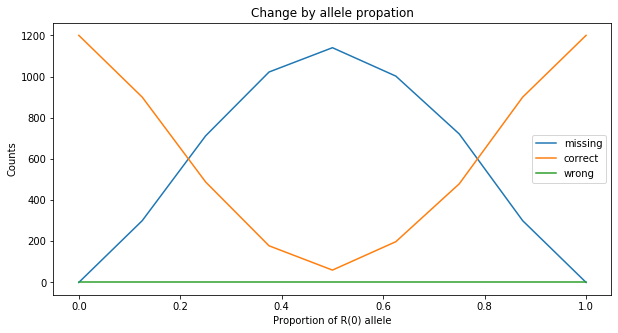

In [13]:
plt.figure(figsize=(10,5))
l1,=plt.plot(control_arr,mis_arr)
l2,=plt.plot(control_arr,correct_arr)
l3,=plt.plot(control_arr,wrong_arr)
plt.legend(handles=[l1,l2,l3],labels=['missing','correct','wrong'],loc='best')
plt.title('Change by allele propation')
plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')
plt.show()

In [14]:
# Test with all homo
mis_arr=[]
correct_arr=[]
wrong_arr=[]
control_arr=[]
control=0
for i in range(pools_size*pools_size+1):
    ra=0
    rr=i
    aa=pools_size*pools_size-rr
    mis=0
    correct=0
    wrong=0
    for j in range(300):
        sample_gt=generate_by_gt(rr,aa,ra) ##
        sample_id=generate_id(sample_gt) #
        result=run_pipeline(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id)
        mis=mis+result['mis']
        correct=correct+result['correct']
        wrong=wrong+result['wrong']
    mis_arr=mis_arr+[mis]
    correct_arr=correct_arr+[correct]
    wrong_arr=wrong_arr+[wrong]
    control_arr=control_arr+[control]
    control=control+1/(pools_size*pools_size)

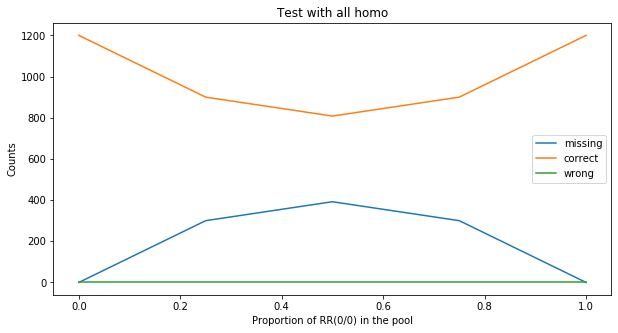

In [15]:
plt.figure(figsize=(10,5))
l1,=plt.plot(control_arr,mis_arr)
l2,=plt.plot(control_arr,correct_arr)
l3,=plt.plot(control_arr,wrong_arr)
plt.legend(handles=[l1,l2,l3],labels=['missing','correct','wrong'],loc='best')
plt.title('Test with all homo')
plt.xlabel('Proportion of RR(0/0) in the pool')
plt.ylabel('Counts')
plt.show()

In [16]:
# Analize the porportion of missing values in each gt

mis00_arr=[]
mis11_arr=[]
mis10_arr=[]
sample10_arr=[]
sample00_arr=[]
sample11_arr=[]
correct_arr=[]
wrong_arr=[]
control_arr=[]
control=0

for i in range(pools_size*pools_size*2):
    all_result=[]
    all_sample=[]
    r=i+1
    a=pools_size*pools_size*2-r
    correct=0
    wrong=0
    for j in range(300):
        sample_gt=generate_by_allele(r,a,pools_size)  ##
        sample_id=generate_id(sample_gt) #
        result=run_pipeline_access_with_gt(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id)
        all_result.append(result)
        all_sample.append(sample_id)
    all_result=np.array(all_result).flatten()
    all_sample=np.array(all_sample).flatten()
    result_count=collections.Counter(all_result)   #count all result about mis[0 1]/correct/wrong
    sample_count=collections.Counter(all_sample)   #count all samples gt
    mis10=result_count['mis[1 0]']+result_count['mis[0 1]']
    mis00=result_count['mis[0 0]']
    mis11=result_count['mis[1 1]']
    sample00=sample_count['rr']
    sample10=sample_count['ar']
    sample11=sample_count['aa']
    
    sample00_arr=sample00_arr+[sample00]
    sample11_arr=sample11_arr+[sample11]
    sample10_arr=sample10_arr+[sample10]
   
    mis00_arr=mis00_arr+[mis00]
    mis11_arr=mis11_arr+[mis11]
    mis10_arr=mis10_arr+[mis10]
    correct_arr=correct_arr+[correct]
    wrong_arr=wrong_arr+[wrong]
    control=control+1/(pools_size*pools_size*2)
    control_arr=control_arr+[control]

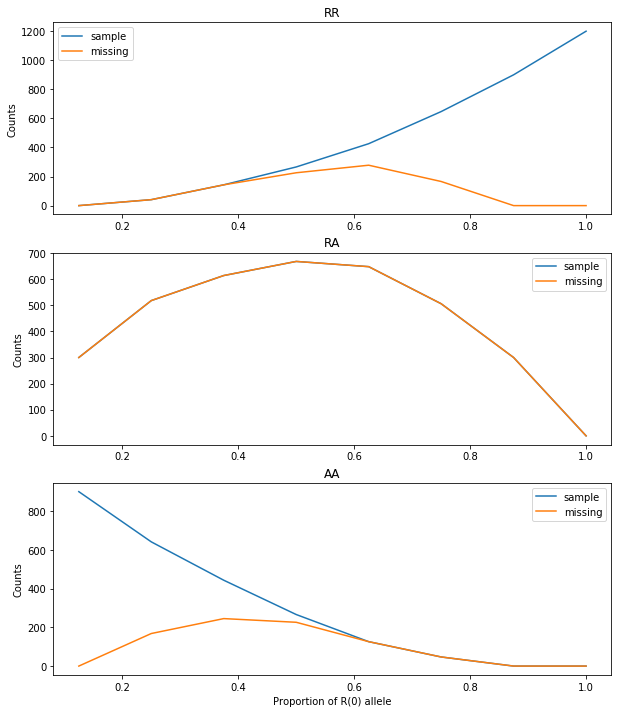

In [17]:
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
l1,=plt.plot(control_arr,sample00_arr)
l2,=plt.plot(control_arr,mis00_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('RR')
# plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')

plt.subplot(3,1,2)
l1,=plt.plot(control_arr,sample10_arr)
l2,=plt.plot(control_arr,mis10_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('RA')
# plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')

plt.subplot(3,1,3)
l1,=plt.plot(control_arr,sample11_arr)
l2,=plt.plot(control_arr,mis11_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('AA')
plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')

plt.show()

In [18]:
mis_arr=[]    ##bnv generated allele
correct_arr=[]
wrong_arr=[]
control_arr=[]
control=0
for i in range(20): #100
#     rate=(i+1)/100
    rate=1/math.pow(10, i)
    mis=0
    correct=0
    wrong=0
    for j in range(300):
        sample_gt=generate_by_allele_bnv(rate,pools_size)  ##
        sample_id=generate_id(sample_gt) #
        result=run_pipeline(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id)
        mis=mis+result['mis']
        correct=correct+result['correct']
        wrong=wrong+result['wrong']
    mis_arr=mis_arr+[mis]
    correct_arr=correct_arr+[correct]
    wrong_arr=wrong_arr+[wrong]
    control=i   
    control_arr=control_arr+[control]

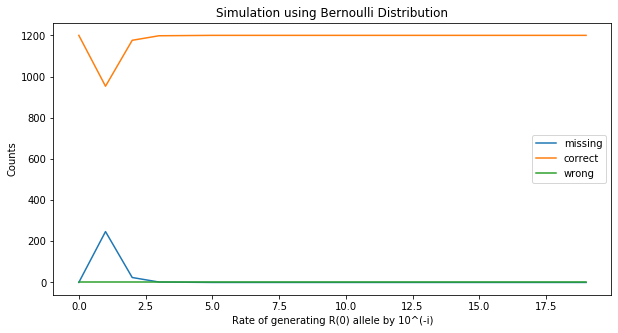

In [19]:
plt.figure(figsize=(10,5))
l1,=plt.plot(control_arr,mis_arr)
l2,=plt.plot(control_arr,correct_arr)
l3,=plt.plot(control_arr,wrong_arr)
plt.legend(handles=[l1,l2,l3],labels=['missing','correct','wrong'],loc='best')
plt.title('Simulation using Bernoulli Distribution')
plt.xlabel('Rate of generating R(0) allele by 10^(-i)')
plt.ylabel('Counts')
plt.show()

In [20]:
# Analize the porportion of missing values in each gt/////bnv

mis00_arr=[]
mis11_arr=[]
mis10_arr=[]
sample10_arr=[]
sample00_arr=[]
sample11_arr=[]
correct_arr=[]
wrong_arr=[]
control_arr=[]
control=0

for i in range(20): #10^0 to 10^19
    all_result=[]
    all_sample=[]
    rate=1/math.pow(10, i)
    correct=0
    wrong=0
    for j in range(300):
        sample_gt=generate_by_allele_bnv(rate,pools_size)  ##
        sample_id=generate_id(sample_gt) #
        result=run_pipeline_access_with_gt(pool_shape,id_len,pools_nb,pools_size,sample_gt,sample_id)
        all_result.append(result)
        all_sample.append(sample_id)
    all_result=np.array(all_result).flatten()
    all_sample=np.array(all_sample).flatten()
    result_count=collections.Counter(all_result)   #count all result about mis[0 1]/correct/wrong
    sample_count=collections.Counter(all_sample)   #count all samples gt
    mis10=result_count['mis[1 0]']+result_count['mis[0 1]']
    mis00=result_count['mis[0 0]']
    mis11=result_count['mis[1 1]']
    sample00=sample_count['rr']
    sample10=sample_count['ar']
    sample11=sample_count['aa']
    
    sample00_arr=sample00_arr+[sample00]
    sample11_arr=sample11_arr+[sample11]
    sample10_arr=sample10_arr+[sample10]
   
    mis00_arr=mis00_arr+[mis00]
    mis11_arr=mis11_arr+[mis11]
    mis10_arr=mis10_arr+[mis10]
    correct_arr=correct_arr+[correct]
    wrong_arr=wrong_arr+[wrong]
    control=i
    control_arr=control_arr+[control]

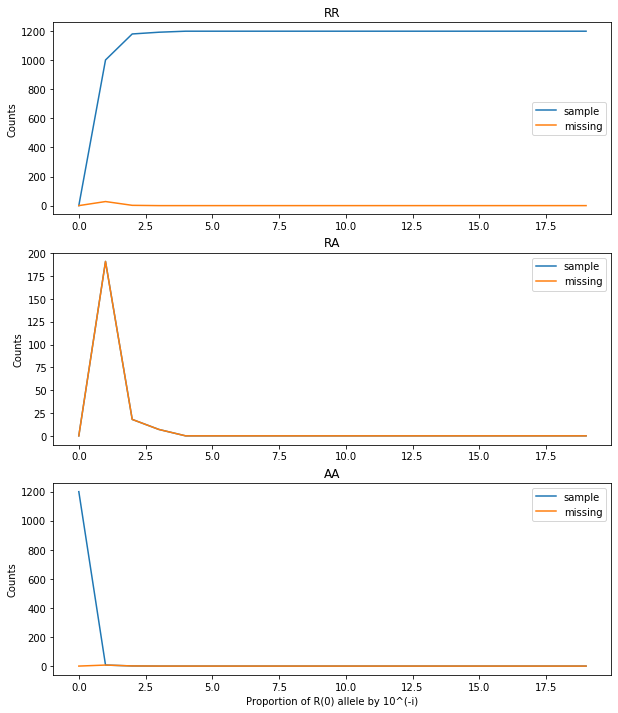

In [21]:
plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
l1,=plt.plot(control_arr,sample00_arr)
l2,=plt.plot(control_arr,mis00_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('RR')
# plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')

plt.subplot(3,1,2)
l1,=plt.plot(control_arr,sample10_arr)
l2,=plt.plot(control_arr,mis10_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('RA')
# plt.xlabel('Proportion of R(0) allele')
plt.ylabel('Counts')

plt.subplot(3,1,3)
l1,=plt.plot(control_arr,sample11_arr)
l2,=plt.plot(control_arr,mis11_arr)
plt.legend(handles=[l1,l2],labels=['sample','missing'],loc='best')
plt.title('AA')
plt.xlabel('Proportion of R(0) allele by 10^(-i)')
plt.ylabel('Counts')

plt.show()
# plt.savefig('temp.png')